
Treinando com Adam | lr=0.1 | epochs=40
Epoch: 0/39		Differential equation loss = 17157.283203		Boundary condition loss = 174143.593750		Total loss = 191300.875000
Epoch: 4/39		Differential equation loss = 16257.338867		Boundary condition loss = 161738.718750		Total loss = 177996.062500
Epoch: 8/39		Differential equation loss = 15028.432617		Boundary condition loss = 148980.640625		Total loss = 164009.078125
Epoch: 12/39		Differential equation loss = 13528.671875		Boundary condition loss = 136836.812500		Total loss = 150365.484375
Epoch: 16/39		Differential equation loss = 12019.177734		Boundary condition loss = 125511.609375		Total loss = 137530.781250
Epoch: 20/39		Differential equation loss = 10838.416016		Boundary condition loss = 114654.523438		Total loss = 125492.937500
Epoch: 24/39		Differential equation loss = 9848.494141		Boundary condition loss = 104417.375000		Total loss = 114265.867188
Epoch: 28/39		Differential equation loss = 9131.063477		Boundary condition loss = 94568.

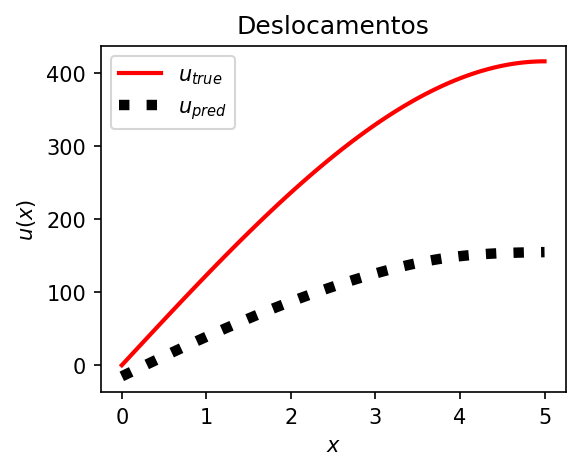

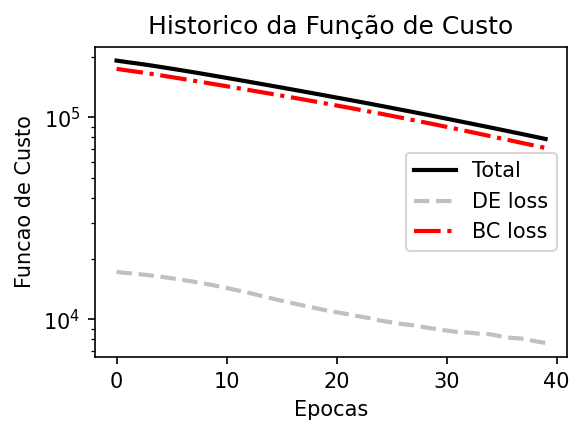


Treinando com Adam | lr=0.1 | epochs=400
Epoch: 0/399		Differential equation loss = 17143.046875		Boundary condition loss = 173819.921875		Total loss = 190962.968750
Epoch: 40/399		Differential equation loss = 7418.639648		Boundary condition loss = 68911.304688		Total loss = 76329.945312
Epoch: 80/399		Differential equation loss = 3025.827393		Boundary condition loss = 19891.119141		Total loss = 22916.947266
Epoch: 120/399		Differential equation loss = 1356.567627		Boundary condition loss = 4075.706055		Total loss = 5432.273438
Epoch: 160/399		Differential equation loss = 751.123474		Boundary condition loss = 538.568542		Total loss = 1289.692017
Epoch: 200/399		Differential equation loss = 519.714844		Boundary condition loss = 45.497932		Total loss = 565.212769
Epoch: 240/399		Differential equation loss = 574.401733		Boundary condition loss = 27.458519		Total loss = 601.860229
Epoch: 280/399		Differential equation loss = 432.251617		Boundary condition loss = 35.733582		Total loss = 46

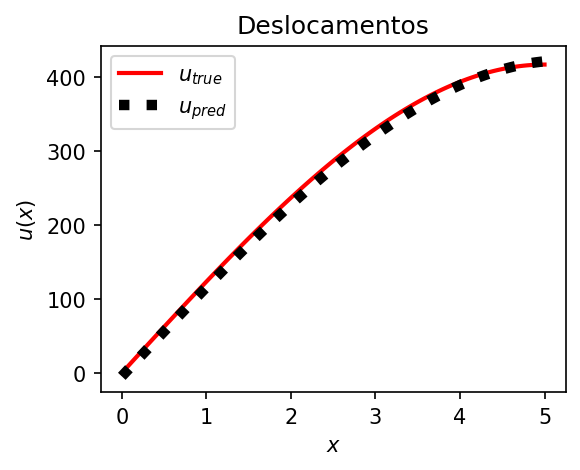

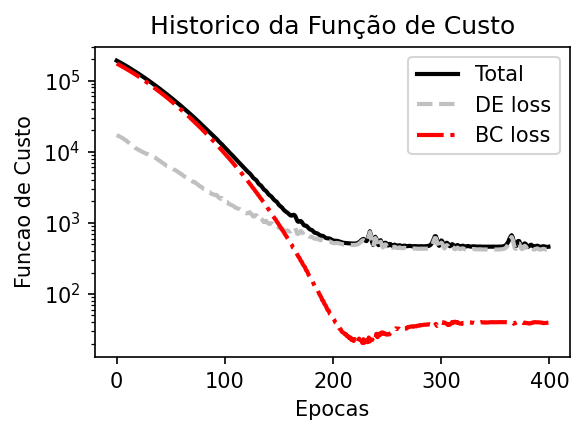


Treinando com Adam | lr=0.1 | epochs=1000
Epoch: 0/999		Differential equation loss = 17144.937500		Boundary condition loss = 173953.140625		Total loss = 191098.078125
Epoch: 100/999		Differential equation loss = 1986.415283		Boundary condition loss = 9360.080078		Total loss = 11346.495117
Epoch: 200/999		Differential equation loss = 565.711609		Boundary condition loss = 47.199188		Total loss = 612.910767
Epoch: 300/999		Differential equation loss = 425.123749		Boundary condition loss = 38.995209		Total loss = 464.118958
Epoch: 400/999		Differential equation loss = 450.404968		Boundary condition loss = 39.196320		Total loss = 489.601288
Epoch: 500/999		Differential equation loss = 449.657379		Boundary condition loss = 40.315968		Total loss = 489.973358
Epoch: 600/999		Differential equation loss = 407.116211		Boundary condition loss = 39.206936		Total loss = 446.323151
Epoch: 700/999		Differential equation loss = 396.178467		Boundary condition loss = 39.652046		Total loss = 435.830505
E

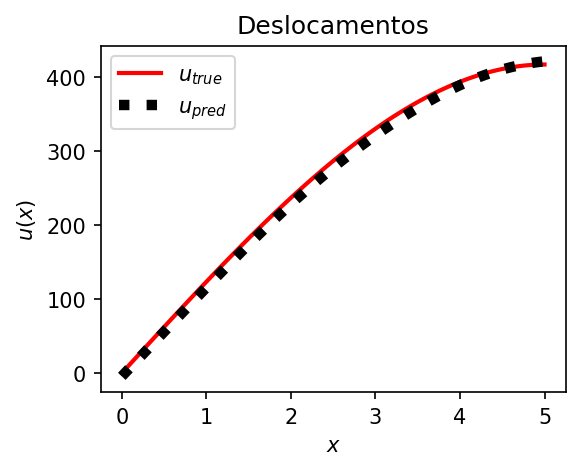

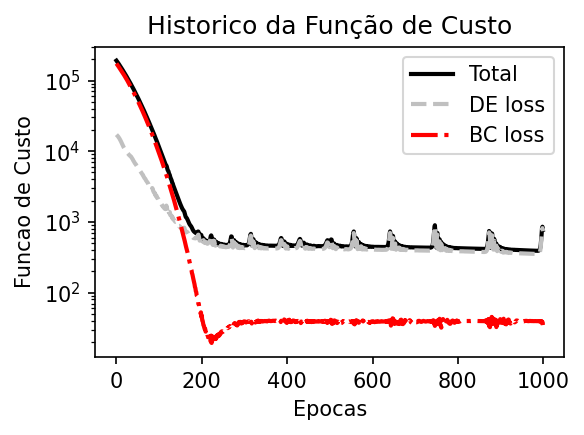


Treinando com Adam | lr=0.01 | epochs=40
Epoch: 0/39		Differential equation loss = 17179.619141		Boundary condition loss = 173965.609375		Total loss = 191145.234375
Epoch: 4/39		Differential equation loss = 17073.464844		Boundary condition loss = 172632.109375		Total loss = 189705.578125
Epoch: 8/39		Differential equation loss = 16967.183594		Boundary condition loss = 171311.187500		Total loss = 188278.375000
Epoch: 12/39		Differential equation loss = 16857.765625		Boundary condition loss = 170005.875000		Total loss = 186863.640625
Epoch: 16/39		Differential equation loss = 16743.494141		Boundary condition loss = 168709.781250		Total loss = 185453.281250
Epoch: 20/39		Differential equation loss = 16623.722656		Boundary condition loss = 167412.390625		Total loss = 184036.109375
Epoch: 24/39		Differential equation loss = 16497.800781		Boundary condition loss = 166102.421875		Total loss = 182600.218750
Epoch: 28/39		Differential equation loss = 16366.492188		Boundary condition loss = 164

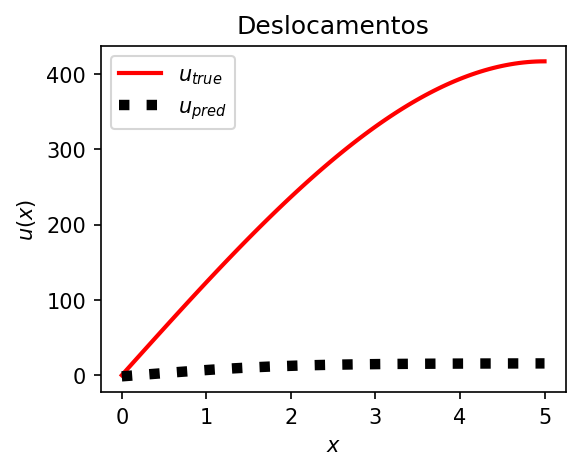

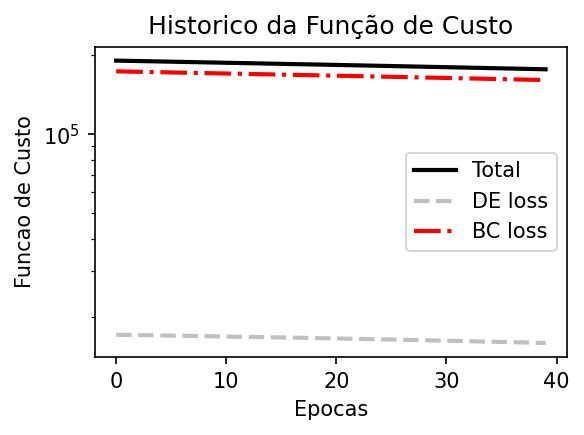


Treinando com Adam | lr=0.01 | epochs=400
Epoch: 0/399		Differential equation loss = 17018.316406		Boundary condition loss = 172904.703125		Total loss = 189923.015625
Epoch: 40/399		Differential equation loss = 15700.203125		Boundary condition loss = 159525.656250		Total loss = 175225.859375
Epoch: 80/399		Differential equation loss = 14015.708008		Boundary condition loss = 146860.875000		Total loss = 160876.578125
Epoch: 120/399		Differential equation loss = 12498.960938		Boundary condition loss = 135337.734375		Total loss = 147836.687500
Epoch: 160/399		Differential equation loss = 11383.248047		Boundary condition loss = 124534.914062		Total loss = 135918.156250
Epoch: 200/399		Differential equation loss = 10695.590820		Boundary condition loss = 114022.289062		Total loss = 124717.882812
Epoch: 240/399		Differential equation loss = 9923.019531		Boundary condition loss = 104274.015625		Total loss = 114197.031250
Epoch: 280/399		Differential equation loss = 9192.886719		Boundary condit

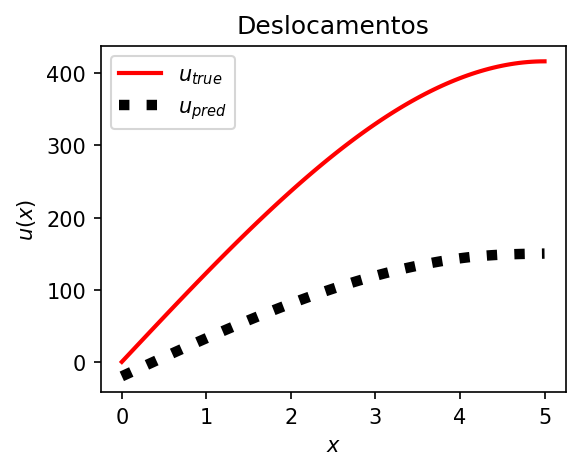

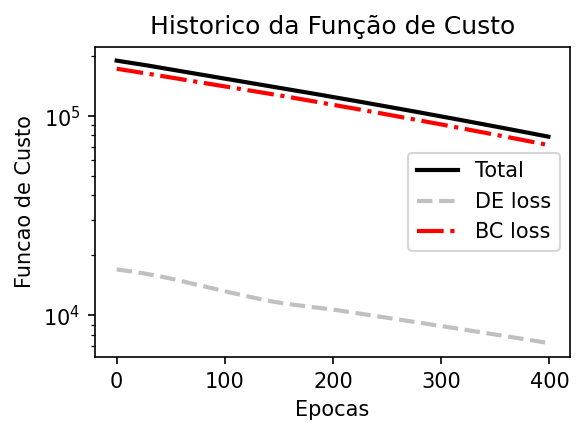


Treinando com Adam | lr=0.01 | epochs=1000
Epoch: 0/999		Differential equation loss = 17081.414062		Boundary condition loss = 173606.109375		Total loss = 190687.531250
Epoch: 100/999		Differential equation loss = 13414.564453		Boundary condition loss = 141424.421875		Total loss = 154838.984375
Epoch: 200/999		Differential equation loss = 10720.846680		Boundary condition loss = 114344.281250		Total loss = 125065.125000
Epoch: 300/999		Differential equation loss = 8877.115234		Boundary condition loss = 91061.281250		Total loss = 99938.398438
Epoch: 400/999		Differential equation loss = 7290.849609		Boundary condition loss = 71609.546875		Total loss = 78900.398438
Epoch: 500/999		Differential equation loss = 5937.000977		Boundary condition loss = 55502.562500		Total loss = 61439.562500
Epoch: 600/999		Differential equation loss = 4804.769043		Boundary condition loss = 42360.871094		Total loss = 47165.640625
Epoch: 700/999		Differential equation loss = 3907.062988		Boundary condition loss

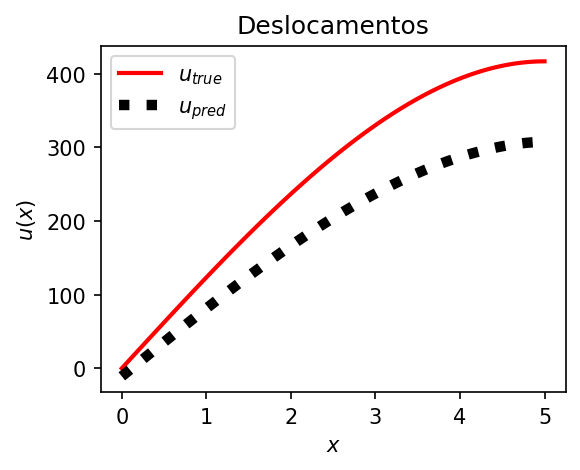

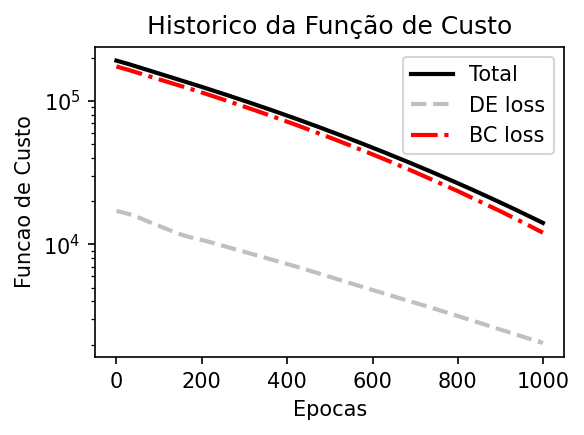


Treinando com Adam | lr=1e-05 | epochs=40
Epoch: 0/39		Differential equation loss = 17154.906250		Boundary condition loss = 173792.578125		Total loss = 190947.484375
Epoch: 4/39		Differential equation loss = 17154.806641		Boundary condition loss = 173791.281250		Total loss = 190946.093750
Epoch: 8/39		Differential equation loss = 17154.707031		Boundary condition loss = 173789.968750		Total loss = 190944.671875
Epoch: 12/39		Differential equation loss = 17154.605469		Boundary condition loss = 173788.640625		Total loss = 190943.250000
Epoch: 16/39		Differential equation loss = 17154.505859		Boundary condition loss = 173787.312500		Total loss = 190941.812500
Epoch: 20/39		Differential equation loss = 17154.406250		Boundary condition loss = 173786.000000		Total loss = 190940.406250
Epoch: 24/39		Differential equation loss = 17154.304688		Boundary condition loss = 173784.703125		Total loss = 190939.000000
Epoch: 28/39		Differential equation loss = 17154.205078		Boundary condition loss = 17

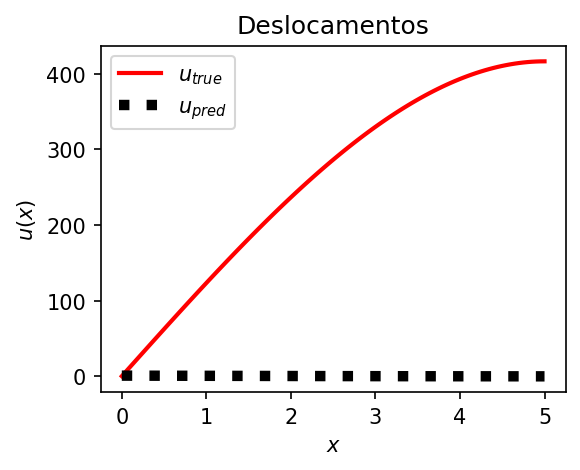

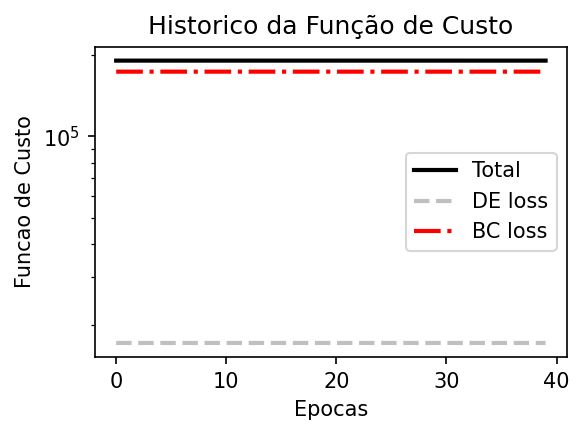


Treinando com Adam | lr=1e-05 | epochs=400
Epoch: 0/399		Differential equation loss = 17104.160156		Boundary condition loss = 173489.609375		Total loss = 190593.765625
Epoch: 40/399		Differential equation loss = 17103.132812		Boundary condition loss = 173476.281250		Total loss = 190579.406250
Epoch: 80/399		Differential equation loss = 17102.105469		Boundary condition loss = 173462.937500		Total loss = 190565.046875
Epoch: 120/399		Differential equation loss = 17101.078125		Boundary condition loss = 173449.625000		Total loss = 190550.703125
Epoch: 160/399		Differential equation loss = 17100.052734		Boundary condition loss = 173436.281250		Total loss = 190536.328125
Epoch: 200/399		Differential equation loss = 17099.025391		Boundary condition loss = 173422.953125		Total loss = 190521.984375
Epoch: 240/399		Differential equation loss = 17097.998047		Boundary condition loss = 173409.609375		Total loss = 190507.609375
Epoch: 280/399		Differential equation loss = 17096.974609		Boundary con

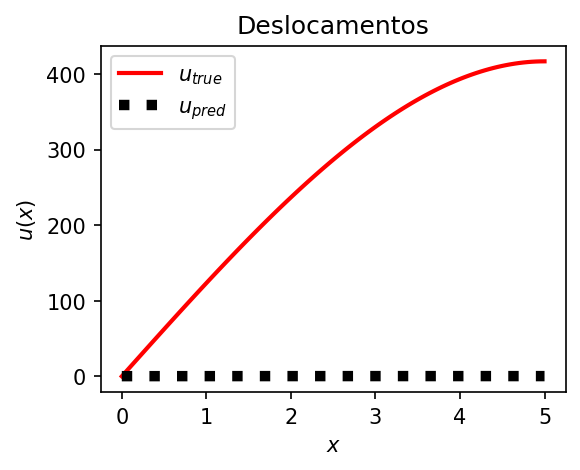

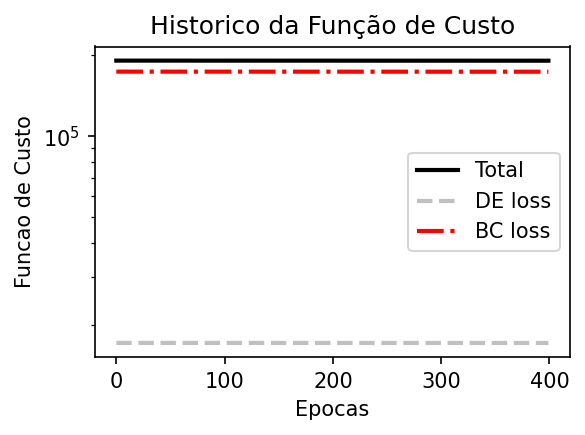


Treinando com Adam | lr=1e-05 | epochs=1000
Epoch: 0/999		Differential equation loss = 17123.197266		Boundary condition loss = 174067.906250		Total loss = 191191.109375
Epoch: 100/999		Differential equation loss = 17121.238281		Boundary condition loss = 174035.984375		Total loss = 191157.218750
Epoch: 200/999		Differential equation loss = 17119.281250		Boundary condition loss = 174004.062500		Total loss = 191123.343750
Epoch: 300/999		Differential equation loss = 17117.332031		Boundary condition loss = 173972.218750		Total loss = 191089.546875
Epoch: 400/999		Differential equation loss = 17115.382812		Boundary condition loss = 173940.390625		Total loss = 191055.781250
Epoch: 500/999		Differential equation loss = 17113.441406		Boundary condition loss = 173908.625000		Total loss = 191022.062500
Epoch: 600/999		Differential equation loss = 17111.501953		Boundary condition loss = 173876.890625		Total loss = 190988.390625
Epoch: 700/999		Differential equation loss = 17109.566406		Boundary 

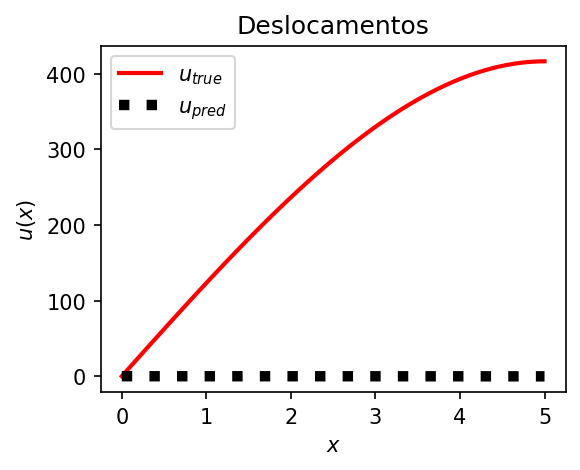

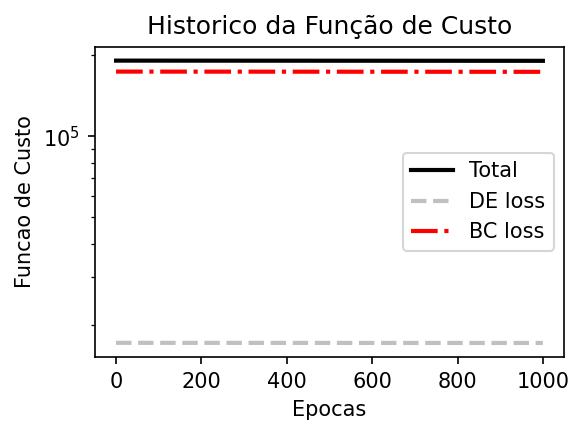


Treinando com LBFGS | lr=0.1 | epochs=40
Epoch: 0/39		Differential equation loss = 17077.792969		Boundary condition loss = 173249.687500		Total loss = 190327.484375
Epoch: 4/39		Differential equation loss = 631.398621		Boundary condition loss = 43.712570		Total loss = 675.111206
Epoch: 8/39		Differential equation loss = 448.762268		Boundary condition loss = 38.097885		Total loss = 486.860168
Epoch: 12/39		Differential equation loss = 438.566833		Boundary condition loss = 31.816420		Total loss = 470.383240
Epoch: 16/39		Differential equation loss = 429.922913		Boundary condition loss = 34.612419		Total loss = 464.535339
Epoch: 20/39		Differential equation loss = 385.939697		Boundary condition loss = 32.864250		Total loss = 418.803955
Epoch: 24/39		Differential equation loss = 267.678772		Boundary condition loss = 31.929394		Total loss = 299.608154
Epoch: 28/39		Differential equation loss = 112.735809		Boundary condition loss = 40.516018		Total loss = 153.251831
Epoch: 32/39		Differenti

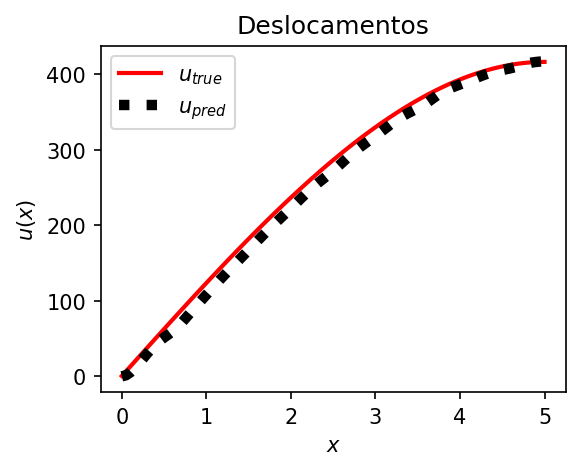

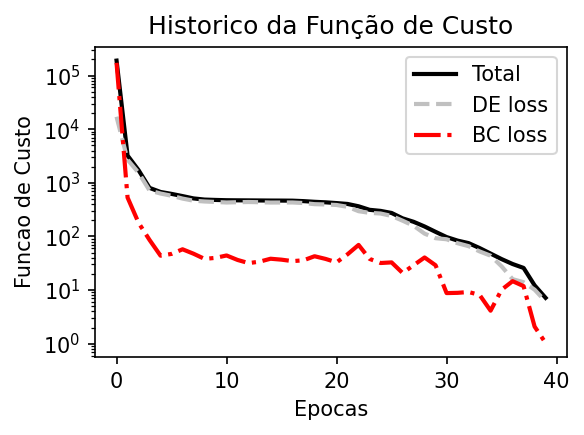


Treinando com LBFGS | lr=0.1 | epochs=400
Epoch: 0/399		Differential equation loss = 17159.572266		Boundary condition loss = 174307.484375		Total loss = 191467.062500
Epoch: 40/399		Differential equation loss = 6.282333		Boundary condition loss = 6.874949		Total loss = 13.157283
Epoch: 80/399		Differential equation loss = 0.000123		Boundary condition loss = 0.000002		Total loss = 0.000124
Epoch: 120/399		Differential equation loss = 0.000161		Boundary condition loss = 0.000004		Total loss = 0.000165
Epoch: 160/399		Differential equation loss = 0.340523		Boundary condition loss = 0.137486		Total loss = 0.478009
Epoch: 200/399		Differential equation loss = 0.022722		Boundary condition loss = 0.002979		Total loss = 0.025702
Epoch: 240/399		Differential equation loss = nan		Boundary condition loss = nan		Total loss = nan
Epoch: 280/399		Differential equation loss = nan		Boundary condition loss = nan		Total loss = nan
Epoch: 320/399		Differential equation loss = nan		Boundary condition los

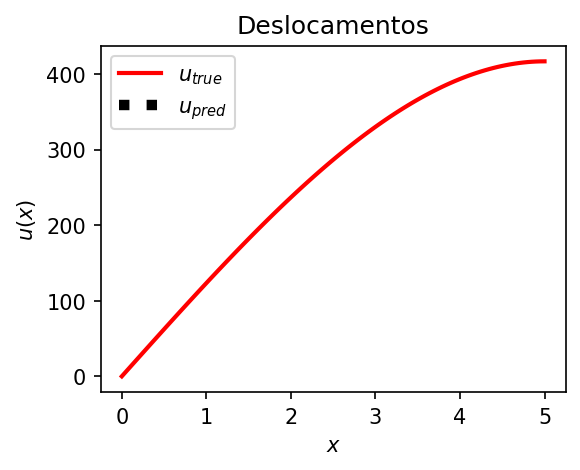

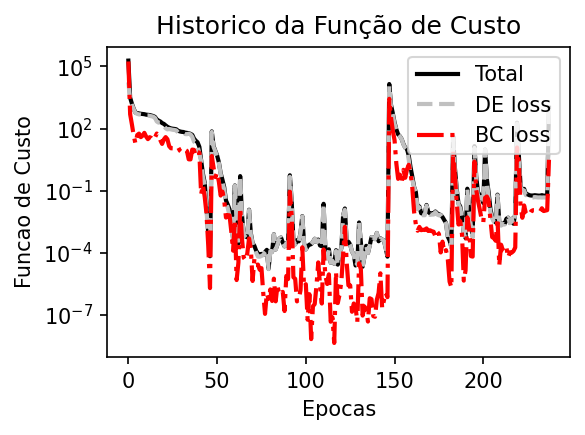


Treinando com LBFGS | lr=0.1 | epochs=1000
Epoch: 0/999		Differential equation loss = 17039.105469		Boundary condition loss = 172798.687500		Total loss = 189837.796875
Epoch: 100/999		Differential equation loss = 0.000203		Boundary condition loss = 0.000000		Total loss = 0.000203
Epoch: 200/999		Differential equation loss = 0.000003		Boundary condition loss = 0.000000		Total loss = 0.000003
Epoch: 300/999		Differential equation loss = 0.000001		Boundary condition loss = 0.000000		Total loss = 0.000001
Epoch: 400/999		Differential equation loss = 0.000001		Boundary condition loss = 0.000000		Total loss = 0.000001
Epoch: 500/999		Differential equation loss = 0.000001		Boundary condition loss = 0.000000		Total loss = 0.000001
Epoch: 600/999		Differential equation loss = 0.000001		Boundary condition loss = 0.000000		Total loss = 0.000001
Epoch: 700/999		Differential equation loss = 0.000001		Boundary condition loss = 0.000000		Total loss = 0.000001
Epoch: 800/999		Differential equation lo

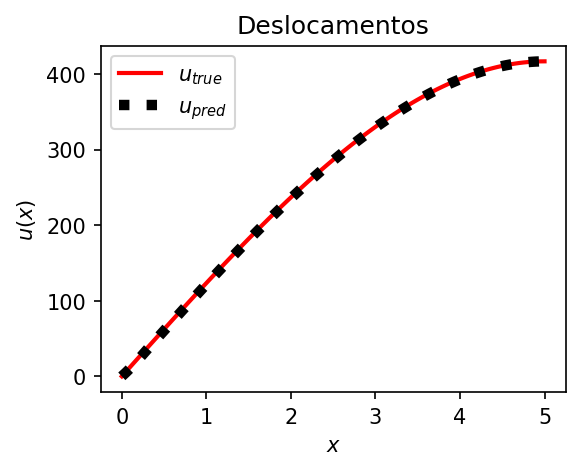

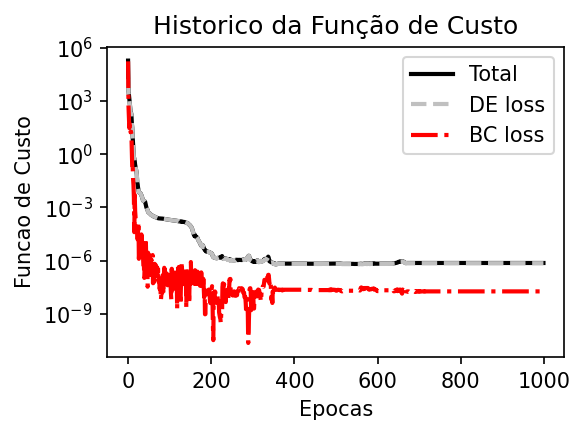


Treinando com LBFGS | lr=0.01 | epochs=40
Epoch: 0/39		Differential equation loss = 17064.466797		Boundary condition loss = 172850.343750		Total loss = 189914.812500
Epoch: 4/39		Differential equation loss = 3798.916504		Boundary condition loss = 20554.318359		Total loss = 24353.234375
Epoch: 8/39		Differential equation loss = 1559.749634		Boundary condition loss = 3417.257568		Total loss = 4977.007324
Epoch: 12/39		Differential equation loss = 910.101013		Boundary condition loss = 514.649902		Total loss = 1424.750977
Epoch: 16/39		Differential equation loss = 680.021667		Boundary condition loss = 66.341171		Total loss = 746.362854
Epoch: 20/39		Differential equation loss = 588.905640		Boundary condition loss = 24.588535		Total loss = 613.494202
Epoch: 24/39		Differential equation loss = 544.100159		Boundary condition loss = 38.336193		Total loss = 582.436340
Epoch: 28/39		Differential equation loss = 509.646912		Boundary condition loss = 58.698208		Total loss = 568.345093
Epoch: 32/3

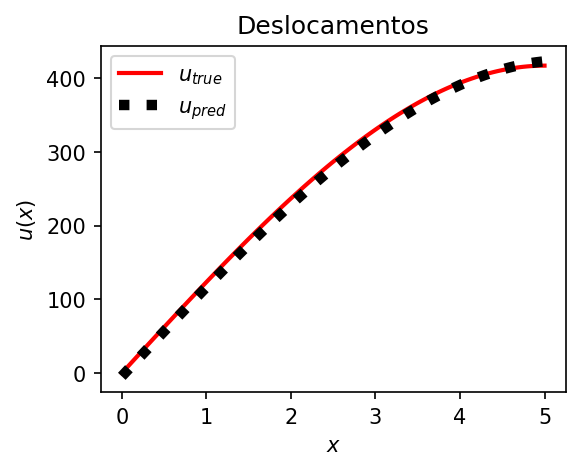

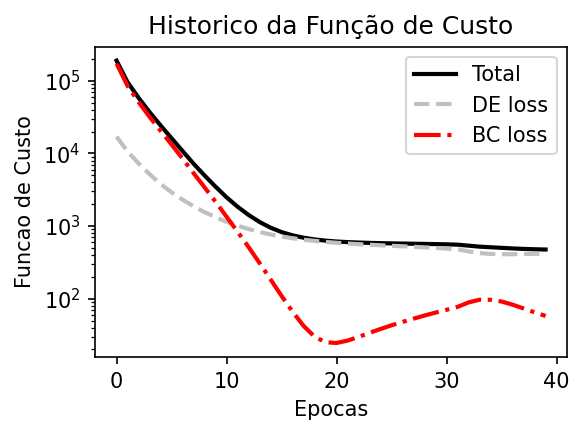


Treinando com LBFGS | lr=0.01 | epochs=400
Epoch: 0/399		Differential equation loss = 17115.134766		Boundary condition loss = 173959.703125		Total loss = 191074.843750
Epoch: 40/399		Differential equation loss = 447.449554		Boundary condition loss = 72.801117		Total loss = 520.250671
Epoch: 80/399		Differential equation loss = 197.148315		Boundary condition loss = 45.600128		Total loss = 242.748444
Epoch: 120/399		Differential equation loss = 65.712883		Boundary condition loss = 1.846724		Total loss = 67.559608
Epoch: 160/399		Differential equation loss = 8.898354		Boundary condition loss = 4.869294		Total loss = 13.767647
Epoch: 200/399		Differential equation loss = 7.852427		Boundary condition loss = 1.596073		Total loss = 9.448500
Epoch: 240/399		Differential equation loss = 5.714209		Boundary condition loss = 0.791835		Total loss = 6.506043
Epoch: 280/399		Differential equation loss = 3.406856		Boundary condition loss = 0.645928		Total loss = 4.052784
Epoch: 320/399		Differential 

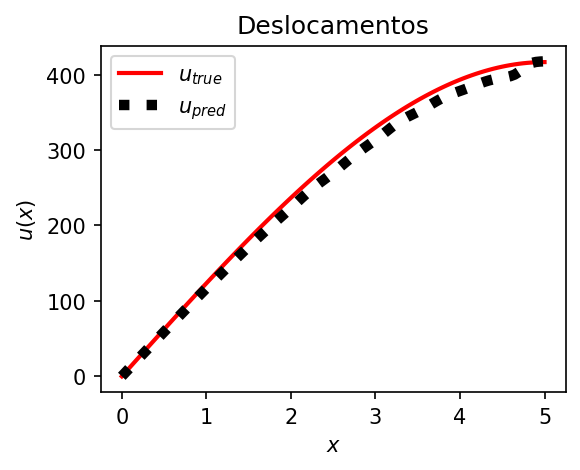

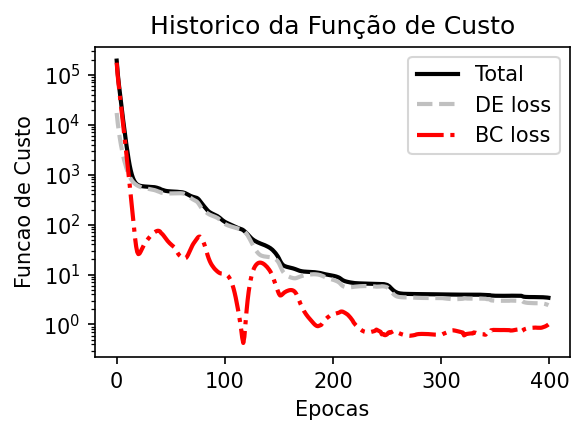


Treinando com LBFGS | lr=0.01 | epochs=1000
Epoch: 0/999		Differential equation loss = 17103.160156		Boundary condition loss = 173809.875000		Total loss = 190913.031250
Epoch: 100/999		Differential equation loss = 6.067342		Boundary condition loss = 5.955873		Total loss = 12.023214
Epoch: 200/999		Differential equation loss = 0.499576		Boundary condition loss = 0.013132		Total loss = 0.512707
Epoch: 300/999		Differential equation loss = 0.194174		Boundary condition loss = 0.137351		Total loss = 0.331525
Epoch: 400/999		Differential equation loss = 0.187930		Boundary condition loss = 0.137724		Total loss = 0.325653
Epoch: 500/999		Differential equation loss = 0.187932		Boundary condition loss = 0.137722		Total loss = 0.325653
Epoch: 600/999		Differential equation loss = 0.187933		Boundary condition loss = 0.137719		Total loss = 0.325653
Epoch: 700/999		Differential equation loss = 0.187936		Boundary condition loss = 0.137716		Total loss = 0.325653
Epoch: 800/999		Differential equation 

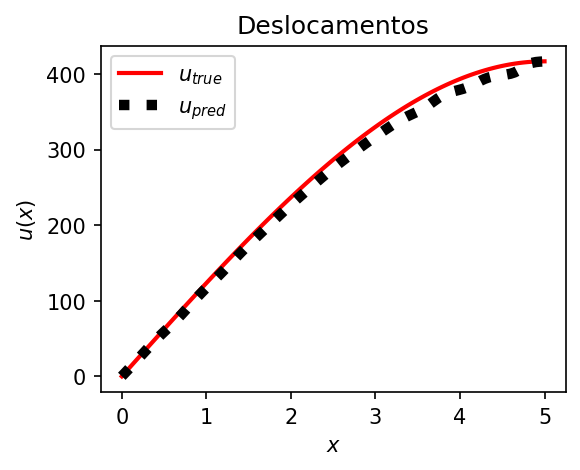

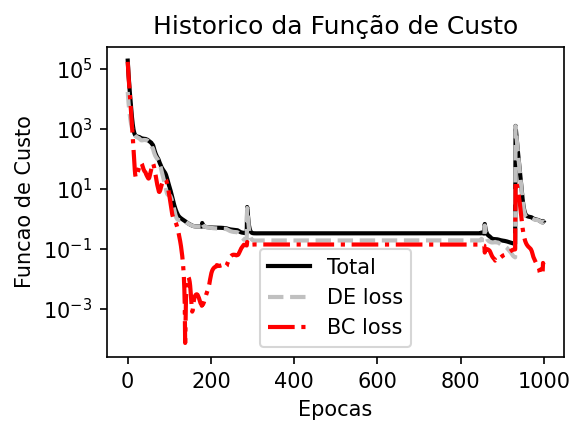


Treinando com LBFGS | lr=1e-05 | epochs=40
Epoch: 0/39		Differential equation loss = 17081.277344		Boundary condition loss = 173258.656250		Total loss = 190339.937500
Epoch: 4/39		Differential equation loss = 16831.183594		Boundary condition loss = 170459.250000		Total loss = 187290.437500
Epoch: 8/39		Differential equation loss = 16581.960938		Boundary condition loss = 167633.140625		Total loss = 184215.093750
Epoch: 12/39		Differential equation loss = 16277.065430		Boundary condition loss = 164120.703125		Total loss = 180397.765625
Epoch: 16/39		Differential equation loss = 15958.533203		Boundary condition loss = 160355.000000		Total loss = 176313.531250
Epoch: 20/39		Differential equation loss = 15632.321289		Boundary condition loss = 156334.140625		Total loss = 171966.468750
Epoch: 24/39		Differential equation loss = 15212.950195		Boundary condition loss = 150890.968750		Total loss = 166103.921875
Epoch: 28/39		Differential equation loss = 15038.401367		Boundary condition loss = 1

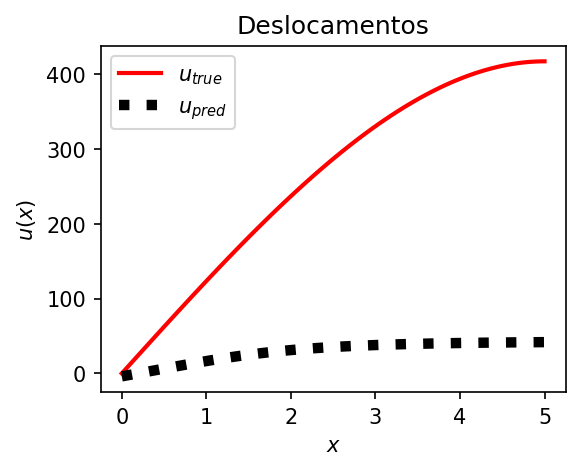

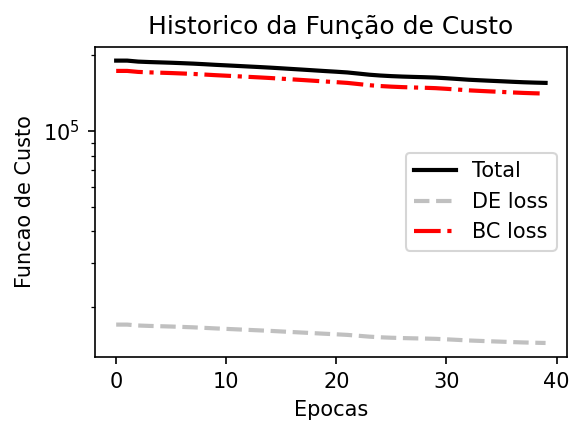


Treinando com LBFGS | lr=1e-05 | epochs=400
Epoch: 0/399		Differential equation loss = 17052.361328		Boundary condition loss = 172995.953125		Total loss = 190048.312500
Epoch: 40/399		Differential equation loss = 13055.295898		Boundary condition loss = 124315.484375		Total loss = 137370.781250
Epoch: 80/399		Differential equation loss = 9155.496094		Boundary condition loss = 83789.945312		Total loss = 92945.437500
Epoch: 120/399		Differential equation loss = 7588.223633		Boundary condition loss = 68228.281250		Total loss = 75816.507812
Epoch: 160/399		Differential equation loss = 6688.395508		Boundary condition loss = 58623.589844		Total loss = 65311.984375
Epoch: 200/399		Differential equation loss = 6180.837891		Boundary condition loss = 51973.386719		Total loss = 58154.226562
Epoch: 240/399		Differential equation loss = 5809.251953		Boundary condition loss = 46251.824219		Total loss = 52061.078125
Epoch: 280/399		Differential equation loss = 5220.404297		Boundary condition loss = 3

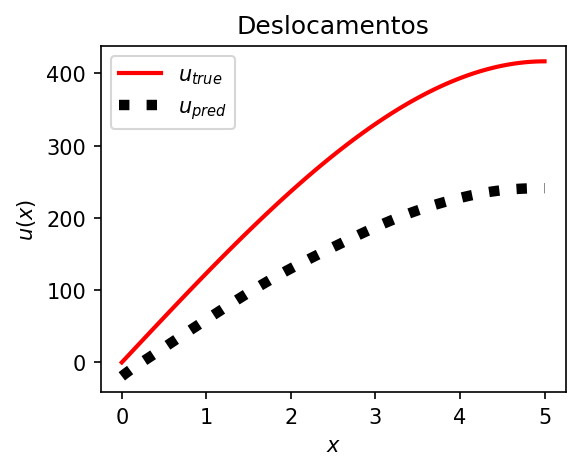

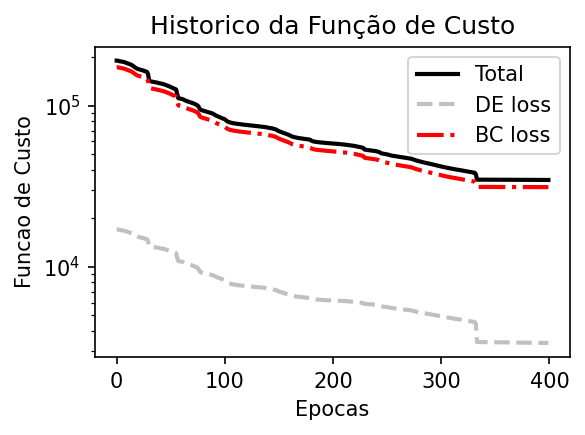


Treinando com LBFGS | lr=1e-05 | epochs=1000
Epoch: 0/999		Differential equation loss = 17071.304688		Boundary condition loss = 173009.109375		Total loss = 190080.406250
Epoch: 100/999		Differential equation loss = 12039.384766		Boundary condition loss = 102901.960938		Total loss = 114941.343750
Epoch: 200/999		Differential equation loss = 7348.833008		Boundary condition loss = 56560.851562		Total loss = 63909.683594
Epoch: 300/999		Differential equation loss = 3665.287598		Boundary condition loss = 33586.003906		Total loss = 37251.292969
Epoch: 400/999		Differential equation loss = 1418.633057		Boundary condition loss = 26398.283203		Total loss = 27816.916016
Epoch: 500/999		Differential equation loss = 870.583252		Boundary condition loss = 21719.783203		Total loss = 22590.367188
Epoch: 600/999		Differential equation loss = 643.549805		Boundary condition loss = 16473.091797		Total loss = 17116.640625
Epoch: 700/999		Differential equation loss = 555.615845		Boundary condition loss = 1

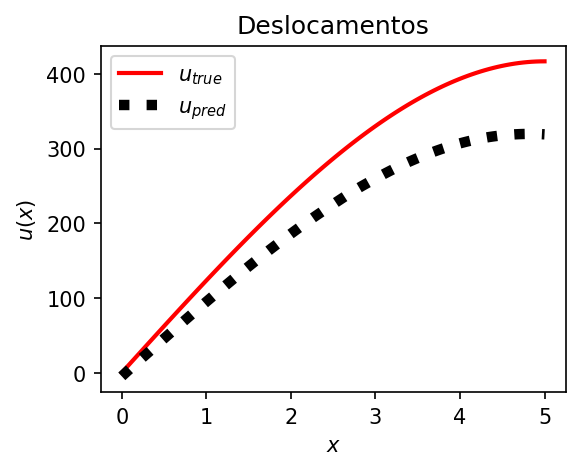

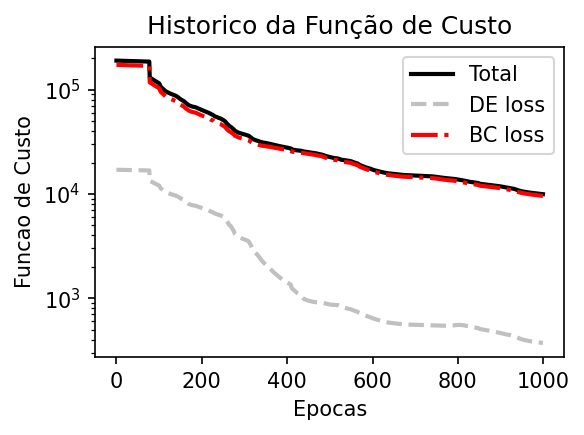

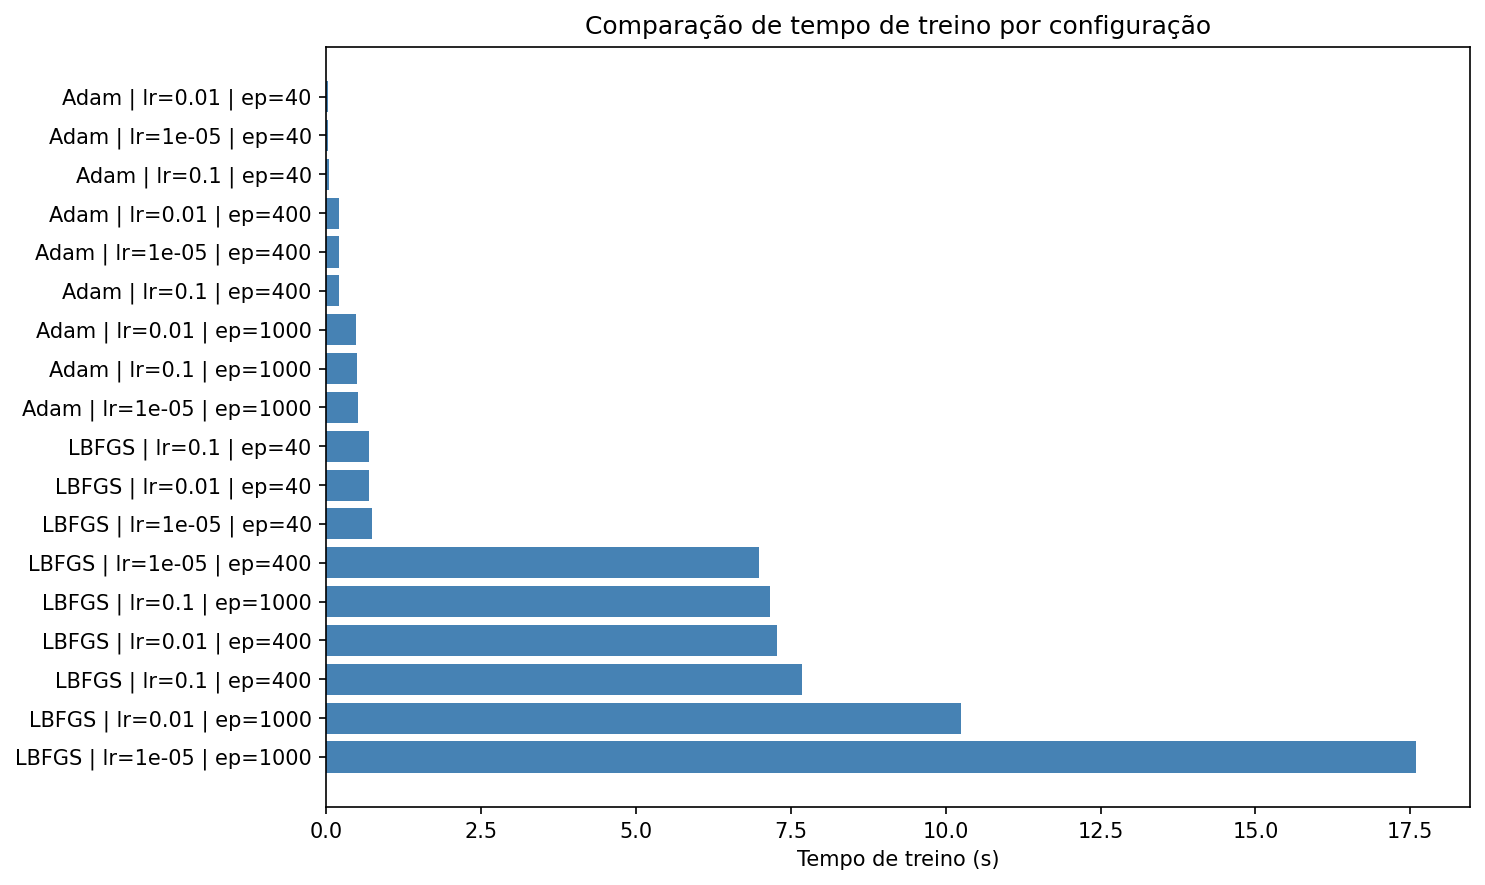

In [61]:
import torch
from torch.autograd import grad
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager
from matplotlib import rc
import numpy as np
import time
import pandas as pd

dtype = torch.float
device = torch.device("cpu")

def generate_grid_1d(length, samples=20, initial_coordinate=0.0):
    x = torch.linspace(initial_coordinate, initial_coordinate + length, samples, requires_grad=True)
    return x.view(samples, 1)

def get_derivative(y, x, n):
    if n == 0:
        return y
    else:
        dy_dx = grad(y, x, torch.ones(x.size()[0], 1, device=device), create_graph=True, retain_graph=True)[0]
        return get_derivative(dy_dx, x, n - 1)

def build_model(input_dimension, hidden_dimension, output_dimension):
    modules=[]
    modules.append(torch.nn.Linear(input_dimension, hidden_dimension[0]))
    modules.append(torch.nn.Tanh())
    for i in range(len(hidden_dimension)-1):
        modules.append(torch.nn.Linear(hidden_dimension[i], hidden_dimension[i+1]))
        modules.append(torch.nn.Tanh())
    modules.append(torch.nn.Linear(hidden_dimension[-1], output_dimension))
    model = torch.nn.Sequential(*modules)
    return model

class PhysicsInformedBarModel:
    def __init__(self, E, A, L, u0, dist_load):
        self.E = E
        self.A = A
        self.L = L
        self.x = generate_grid_1d(L)
        self.u0 = u0
        self.dist_load = dist_load
        self.model = build_model(1,[40],1)
        self.EDP_loss_history = None
        self.ICBC_loss_history = None
        self.total_loss_history = None
        self.optimizer = None

    def get_displacements(self, x):
        u = self.model(x)
        return u

    def costFunction(self, x, u_pred):
        EDP = get_derivative(self.E(x) * self.A(x) * get_derivative(u_pred, x, 1), x, 1) + self.dist_load(x)
        EDP_loss = torch.sum(EDP ** 2).view(1)
        ICBC_loss = 0
        ICBC_loss += (u_pred[0] - self.u0[0]) ** 2
        ICBC_loss += (u_pred[-1] - self.u0[1]) ** 2
        return EDP_loss, ICBC_loss

    def closure(self):
        self.optimizer.zero_grad()
        u_pred = self.get_displacements(self.x)
        loss = self.costFunction(self.x, u_pred)
        loss = loss[0] + loss[1]
        loss.backward(retain_graph=True)
        return loss

    def train(self, epochs, print_every, optimizer='Adam', **kwargs):
        if optimizer=='Adam':
            self.optimizer = torch.optim.Adam(self.model.parameters(), **kwargs)
        elif optimizer=='LBFGS':
            self.optimizer = torch.optim.LBFGS(self.model.parameters(), **kwargs)

        self.PDE_loss_history = np.zeros(epochs)
        self.ICBC_loss_history = np.zeros(epochs)
        self.total_loss_history = np.zeros(epochs)

        for i in range(epochs):
            u_pred = self.get_displacements(self.x)
            PDE_loss, ICBC_loss = self.costFunction(self.x, u_pred)
            total_loss = PDE_loss + ICBC_loss
            self.PDE_loss_history[i] += PDE_loss
            self.ICBC_loss_history[i] += ICBC_loss
            self.total_loss_history[i] += total_loss
            self.print_training_state(i, epochs, print_every)
            self.optimizer.step(self.closure)

    def print_training_state(self, epoch, epochs, print_every):
        if epoch == 0 or epoch == (epochs - 1) or epoch % print_every == 0 or print_every == 'all':
            string = "Epoch: {}/{}\t\tDifferential equation loss = {:2f}\t\tBoundary condition loss = {:2f}\t\tTotal loss = {:2f}"
            print(string.format(epoch, epochs - 1, self.PDE_loss_history[epoch],
                                self.ICBC_loss_history[epoch], self.total_loss_history[epoch]))

    def plot_training_history(self, yscale='log'):
        fig, ax = plt.subplots(figsize=(4,3))
        ax.set_title("Historico da Fun\u00e7\u00e3o de Custo")
        ax.set_xlabel("Epocas")
        ax.set_ylabel("Funcao de Custo")
        plt.yscale(yscale)
        ax.plot(self.total_loss_history, 'k', linewidth=2, label="Total")
        ax.plot(self.PDE_loss_history, color='silver', linestyle='--', linewidth=2, label="DE loss")
        ax.plot(self.ICBC_loss_history, color='r', linestyle='-.', linewidth=2, label="BC loss")
        ax.legend()
        fig.tight_layout()
        plt.show()

matplotlib.rcParams["figure.dpi"] = 150
rc('text', usetex=False)

def plot_displacements_bar(x, u, u_analytic=None):
    fig, ax = plt.subplots(figsize=(4,3))
    ax.set_title("Deslocamentos")
    ax.set_xlabel("$x$")
    ax.set_ylabel("$u(x)$")
    if u_analytic != None:
        ax.plot(x.detach().numpy(), u_analytic(x.detach().numpy()),color='r', linewidth=2, label="$u_{true}$")
    ax.plot(x.detach().numpy(), u.detach().numpy(),color='k',linestyle=':',linewidth=5, label="$u_{pred}$")
    ax.legend()
    plt.show()
    fig.tight_layout()

# Dados do problema
E = lambda x: 1 + 0*x
A = lambda x: 1 + 0*x
L = 5
C = 10
q = lambda x: C * x
u0 = [0.0, (C * L**3) / (3 * 1)]
solucao_analitica = lambda x: (C / (E(x) * A(x))) * ((L**2 * x / 2) - x**3 / 6)

# Parametros para os testes
optimizers = ['Adam', 'LBFGS']
learning_rates = [0.1, 0.01, 1e-5]
epochs_list = [40, 400, 1000]

resultados_treinamento = []

for optimizer in optimizers:
    for lr in learning_rates:
        for epochs in epochs_list:
            print(f"\nTreinando com {optimizer} | lr={lr} | epochs={epochs}")
            pinnModel = PhysicsInformedBarModel(E, A, L, u0, dist_load=q)
            print_every = max(1, epochs // 10)
            start_time = time.time()
            pinnModel.train(epochs=epochs, print_every=print_every, optimizer=optimizer, lr=lr)
            end_time = time.time()
            elapsed = end_time - start_time
            print(f"\u23f1\ufe0f Tempo de treino: {elapsed:.2f} segundos")
            resultados_treinamento.append({
                'optimizer': optimizer,
                'learning_rate': lr,
                'epochs': epochs,
                'tempo_segundos': elapsed
            })
            x_test = generate_grid_1d(L, 100)
            u_test = pinnModel.get_displacements(x_test)
            plot_displacements_bar(x_test, u_test, u_analytic=solucao_analitica)
            pinnModel.plot_training_history()

# Plotando comparativo de tempo
df_resultados = pd.DataFrame(resultados_treinamento)
df_resultados = df_resultados.sort_values(by='tempo_segundos', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(
    [f"{row.optimizer} | lr={row.learning_rate} | ep={row.epochs}" for _, row in df_resultados.iterrows()],
    df_resultados['tempo_segundos'],
    color='steelblue'
)
plt.xlabel("Tempo de treino (s)")
plt.title("Comparação de tempo de treino por configuração")
plt.tight_layout()
plt.show()